In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import music21 as m21
import logging
import sys
from music21 import converter

logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

console_handler = logging.StreamHandler(sys.stdout)
console_handler.setLevel(logging.DEBUG)

file_handler = logging.FileHandler('../logs/chordify.log', mode='w')
file_handler.setLevel(logging.DEBUG)

logger.handlers = [console_handler, file_handler]

plt.style.use('seaborn-paper')
%load_ext music21.ipython21
%matplotlib inline

The music21.ipython21 extension is already loaded. To reload it, use:
  %reload_ext music21.ipython21


In [62]:
TEST_FILENAME_XML = '../output/xml/0139df068310e5a9b2863c8a15734f34299acae3.xml'
TEST_FILENAME_CSV = TEST_FILENAME_XML.replace('xml', 'csv')

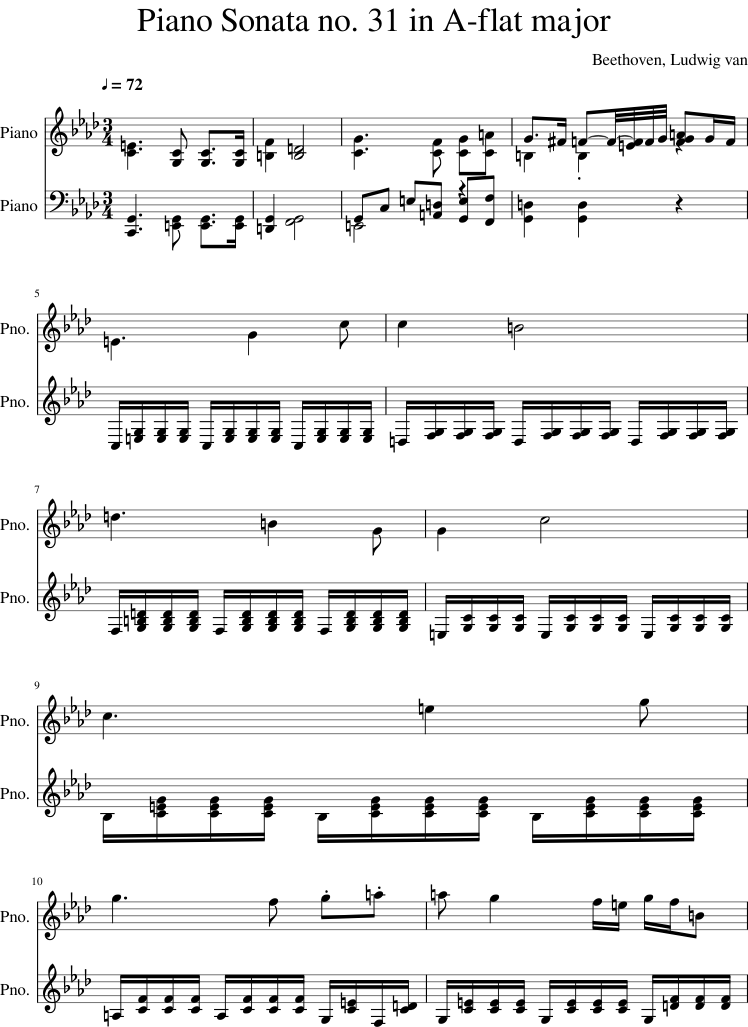

In [63]:
score = converter.parseFile(TEST_FILENAME_XML)
score.show()

/usr/lib/python3.5/site-packages/pandas/core/indexing.py:420: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/usr/lib/python3.5/site-packages/ipykernel/__main__.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/lib/python3.5/site-packages/ipykernel/__main__.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-vie

Chordifing... Discr. step = 120, Last event = 41879


/usr/lib/python3.5/site-packages/ipykernel/__main__.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


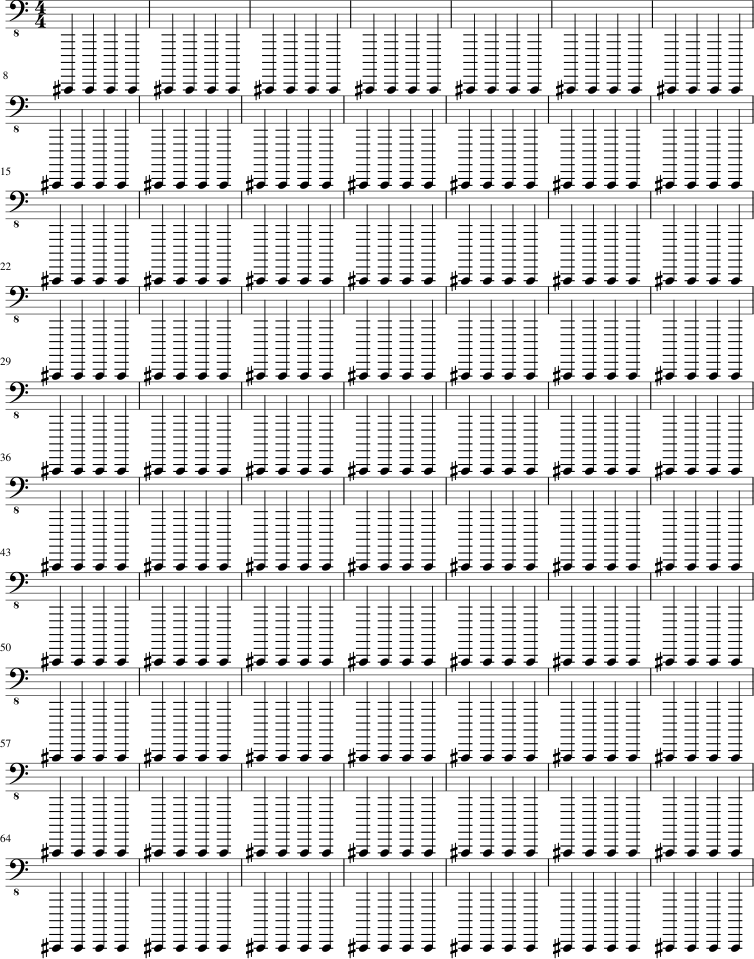

In [68]:
midigram = load_midigram(TEST_FILENAME_CSV)
stream = get_chord_stream(midigram)
stream.show()

In [53]:
import re
from itertools import takewhile

class Midigram:
    def __init__(self, metadata, notes_data, control_data):
        self.metadata = metadata
        self.notes_data = notes_data
        self.control_data = control_data

        
def parse_file_metadata_line(line):
    assert line.startswith('Format')
    result = {}
    
    match = re.search('Format (\d+) MIDI file', line)
    if match is not None:
        result['midi_format'] = match.groups(1)[0]
    
    match = re.search('(\d+) tracks', line)                  
    if match is not None:
        result['tracks'] = match.groups(1)[0]
        
    match = re.search('(\d+) ticks per quarter note', line)
    if match is not None:
        result['ticks_per_note'] = match.groups(1)[0]
        
    return result
        
def parse_track_metadata_line(line):
    assert line.startswith('Track')
    result = {}
    
    match = re.search('Track (\d+)', line)
    if match is not None:
        result['number'] = match.groups(1)[0]
        
    match = re.search('length (\d+)', line)
    if match is not None:
        result['length'] = match.groups(1)[0]
        
    return result
    

def parse_midigram_header(path):
    
    with open(path, 'r') as input_file:
        file_metadata_line = input_file.readline()
        file_metadata = parse_file_metadata_line(file_metadata_line)
        
        file_metadata['header_lines'] = 1
        file_metadata['tracks'] = []
        
        for track_metadata_line in takewhile(lambda l: l.startswith('Track'), input_file):
            track_metadata = parse_track_metadata_line(track_metadata_line)
            file_metadata['tracks'].append(track_metadata)
            file_metadata['header_lines'] += 1

        return file_metadata
            

def load_midigram(path):
    metadata = parse_midigram_header(path)
    data = pd.read_csv(path, 
                       header=None, 
                       skiprows=int(metadata['header_lines']),
                       names=['track', 'start', 'type', 'meta', 'pitch', 'velocity'])

    data['type'] = data['type'].apply(lambda s: str(s).lower().strip())
    control_data = data[data['type'].isin(['time_signature'])]
    notes_data = data[data['type'].isin(['note_on_c', 'note_off_c'])]

    # sometimes note_off_c is encoded as note_on_c with 0 velocity
    # what sick bastard thought that it was a good idea?
    notes_data.loc[(data['type'] == 'note_on_c') & (data['velocity'] == 0), 'type'] = 'note_off_c'
    
    notes_data['start'] = notes_data['start'].astype(np.int32)
    notes_data['pitch'] = notes_data['pitch'].astype(np.int32)
    notes_data['velocity'] = notes_data['velocity'].astype(np.int32)

    return Midigram(metadata, notes_data, control_data)

In [101]:
from scipy.stats.mstats import mode
from music21.chord import Chord
from music21.pitch import Pitch
from music21.note import Rest

def choridfy(midigram):
    
    discretization_step = int(midigram.metadata['ticks_per_note'])
    event_times = midigram.notes_data['start']    
    current_pitches = set()
    last_event_time = max(event_times)
    
    logger.debug('Chordifing... Discr. step = {0}, Last event = {1}'.format(discretization_step, last_event_time))
    
    for current_time in range(0, last_event_time, discretization_step):
        current_range = (event_times >= current_time) & (event_times < current_time + discretization_step)
        current_events = midigram.notes_data[current_range].groupby(by=['pitch'])['type']
        
        added_pitches = current_events.agg(lambda e: (e == 'note_on_c').count()
        for pitch in added_pitches:
            current_pitches.add(pitch)
            
        if any(current_pitches):
            pitches = [Pitch(midi=p) for p in current_pitches]
            yield Chord(pitches)
        else:
            yield Rest()
            
        removed_pitches = current_events.agg(lambda e: (e == 'note_off_c').count()
        for pitch in removed_pitches:
            current_pitches.discard(pitch)
            
        """
        logger.debug('Current time: %d. Added: <%s>. Removed: <%s>', 
                     current_time, 
                     ', '.join(map(str, added_pitches)), 
                     ', '.join(map(str, removed_pitches)))
        """

In [7]:
def get_chord_string(chord):
    if isinstance(chord, Rest):
        return '<rest>'
    
    return '{0}{1}'.format(chord.root(), chord.normalFormString)

In [13]:
from music21.stream import Stream

def get_chord_stream(midigram):
    stream = Stream()
    for chord in choridfy(midigram):
        stream.append(chord)
                      
    return stream

In [8]:
def get_chordified_text(midigram):
    chords = choridfy(midigram)
    words = list(map(get_chord_string, chords))
    return ' '.join(words)

In [10]:
def csv_to_chords(filename, result_filename=None):     
    midigram = load_midigram(filename)
    logger.debug('Midigram size: {0}'.format(len(midigram.data.index)))
    text = get_chordified_text(midigram)
    
    if result_filename is not None: # is there an elegant way in Python to handle both?
        with open(result_filename, 'w') as f:
            f.write(text)
    else:
        print(text)

In [32]:
midigram = load_midigram(TEST_FILENAME_CSV)
print(midigram.metadata)
midigram.data.head()

Exception ignored in: 'pandas.parser.TextReader._tokenize_rows'
Traceback (most recent call last):
  File "pandas/parser.pyx", line 1840, in pandas.parser.raise_parser_error (pandas/parser.c:23056)
pandas.parser.CParserError: Error tokenizing data. C error: Expected 6 fields in line 9, saw 7

/usr/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2821: DtypeWarning: Columns (0,3) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


{'header_lines': 3, 'tracks': [{'length': '83', 'number': '1'}, {'length': '5761', 'number': '2'}], 'midi_format': '1', 'ticks_per_note': '384'}


,track,start,type,meta,pitch,velocity
8,2,0,note_on_c,0,72,77
9,2,768,note_off_c,0,72,0
10,2,768,note_on_c,0,76,77
11,2,1152,note_off_c,0,76,0
12,2,1152,note_on_c,0,79,77


In [36]:
stream.write('midi', 'chordified_sample.mid')

'chordified_sample.mid'

In [12]:
import re

def decode_chord_string(word):
    if word == '<rest>':
        return Rest
    
    match = re.match('([-A-G#\d]+)<(\w+)>', word)
    assert match is not None
    
    root_string = match.group(1)
    notes_string = match.group(2)
    
    print('Root: {0}. Notes: {1}'.format(root_string, notes_string))
    
    root = Pitch(root_string)
    steps = list(notes_string)

SyntaxError: invalid syntax (<ipython-input-12-ac6329137698>, line 17)

In [16]:
midigram = load_midigram(TEST_FILENAME_CSV)
text = get_chordified_text(midigram)
text

/usr/lib/python3.5/site-packages/ipykernel/__main__.py:5: Music21DeprecationWarning: Chord.normalFormString was deprecated on July 2016 and will disappear at or after September 2016. Deprecated because it gives the wrong answer -- use normalOrderString
/usr/lib/python3.5/site-packages/music21-3.0.4-py3.5.egg/music21/chord/__init__.py:3780: Music21DeprecationWarning: Chord.normalForm was deprecated on July 2016 and will disappear at or after September 2016. Deprecated because it gives the wrong answer -- use normalOrder
  return Chord.formatVectorString(self.normalForm)


'C5<0> C5<0> C5<05> C5<05> C5<04> C5<04> C5<05> C5<05> C4<04> C4<04> E5<03> E5<03> E4<03> E4<03> G4<0> G4<0> B4<03> B4<03> G4<04> G4<04> B4<06> B4<06> C5<05> G4<05> C5<0> C5<0> C5<05> C5<05> E4<0> E4<0> G4<0> G4<0> A5<03> A5<03> A4<0> A4<0> F4<04> F4<04> A4<0> A4<0> C4<05> C4<05> G4<0> G4<0> C6<04> C6<04> C6<05> C6<05> G5<04> G5<04> G4<0> G4<0> D4<03> D4<03> E5<03> G4<02> C4<04> C4<04> E5<03> E5<03> E4<0> E4<0> G4<0> G4<0> F4<04> F4<04> B4<06> F4<05> D5<0> E5<0> F5<0> G5<0> A5<0> G5<0> F5<0> E5<0> D5<025> F3<05> B4<016> F3<047> E3<03> E3<03> A4<05> E3<05> C5<0> D5<0> E5<0> F5<0> G5<0> F5<0> E5<0> D5<0> C5<04> C4<015> A4<037> C4<047> D3<03> D3<03> G4<05> D3<05> B4<0> C5<0> D5<0> E5<0> F5<0> E5<0> D5<0> C5<0> B4<03> B3<025> G4<047> B3<036> C3<04> C3<04> F4<05> C3<05> A4<0> B4<0> C5<0> D5<0> E5<0> D5<0> C5<0> B4<0> A4<037> C3<047> F4<045> C3<04> D4<037> D4<037> F3<015> F4<04> F3<024> F3<04> B4<046> F3<048> D5<037> F3<04> B4<046> F3<048> D5<037> F3<015> F5<04> F3<024> A5<0> B5<0> C6<0> B5<

In [35]:
metadata = pd.read_csv('../output/metadata.csv', index_col=0)

In [ ]:
for i, filename in metadata['filename_csv'].iteritems():
    if i%10 == 1:
        logger.info('Processed %d files out of %d', i, len(metadata.index))
        
    result_filename = filename.replace('csv', 'chords')
    csv_to_chords(filename, result_filename)
    logger.debug('Processed file {0} of {1}. Filename: {2}'.format(i, len(metadata.index), filename))

In [36]:
metadata.columns

Index(['composer', 'details_url', 'duration', 'filename_xml', 'genre',
       'hasError', 'key', 'name', 'source_url', 'tempo', 'year', 'filename',
       'filename_mid', 'filename_abc', 'year_exact', 'period', 'musical_form',
       'secondary_time_signatures', 'time_signature', 'filename_midigram',
       'filename_csv'],
      dtype='object')